
Instructions Grouped by Dependency Level:

Level 0:
  LD R1, [1000]
  LD R2, [1001]
  LD R6, [1005]
  LD R7, [1006]

Level 1:
  IADD R3, R2, R1
  IMUL R4, R2, R1
  FADD R8, R6, R7

Level 2:
  IADD R5, R3, R4
  ST R3, [1002]
  ST R4, [1003]
  FMUL R9, R8, R6
  ST R8, [1007]

Level 3:
  ST R5, [1004]
  FADD R10, R8, R9
  ST R9, [1008]

Level 4:
  FMUL R11, R8, R10
  ST R10, [1009]

Level 5:
  FMUL R8, R11, R10
  ST R11, [1010]

Level 6:
  AND R9, R8, R11
  OR R12, R8, R11

Level 7:
  ST R12, [1011]
1 :  {'op': 'LD', 'dest': 'R2', 'src1': '1001', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}
len(updated_instructions) :  22
2 :  {'op': 'LD', 'dest': 'R6', 'src1': '1005', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}
len(updated_instructions) :  22
3 :  {'op': 'LD', 'dest': 'R7', 'src1': '1006', 'src2': None, 'stages': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1}}
len(updated_instructions) :  22
4 :  {'op': 'IADD', 'dest': 'R3', 'src1': 'R2', 'src2': 'R1', 'stage

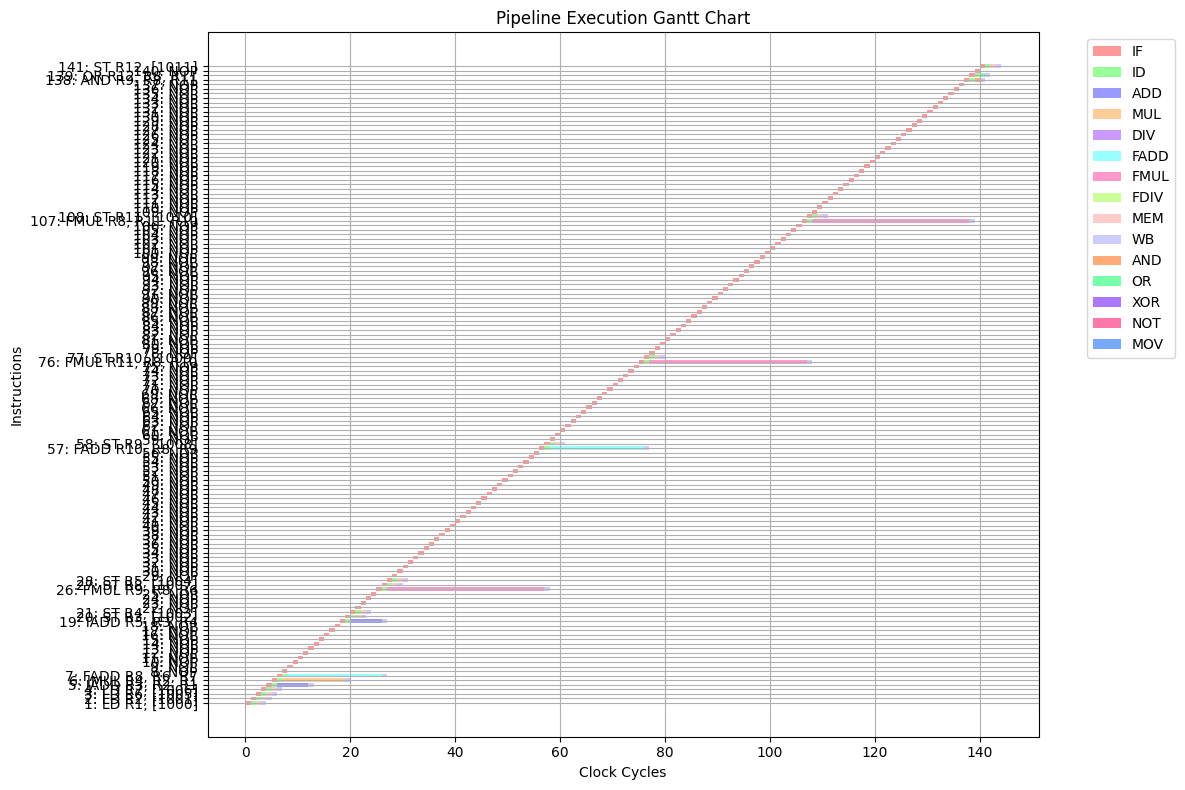

In [ ]:
import re

# Define pipeline stages and latencies
pipeline_stages = {
    # integer
    'IADD': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'ISUB': {'IF': 1, 'ID': 1, 'ADD': 6, 'WB': 1},
    'IMUL': {'IF': 1, 'ID': 1, 'MUL': 12, 'WB': 1},
    'IDIV': {'IF': 1, 'ID': 1, 'DIV': 24, 'WB': 1},

    # floating
    'FADD': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FSUB': {'IF': 1, 'ID': 1, 'FADD': 18, 'WB': 1},
    'FMUL': {'IF': 1, 'ID': 1, 'FMUL': 30, 'WB': 1},
    'FDIV': {'IF': 1, 'ID': 1, 'FDIV': 60, 'WB': 1},

    # logical operations
    'AND': {'IF': 1, 'ID': 1, 'AND': 1, 'WB': 1},
    'OR': {'IF': 1, 'ID': 1, 'OR': 1, 'WB': 1},
    'XOR': {'IF': 1, 'ID': 1, 'XOR': 1, 'WB': 1},
    'NOT': {'IF': 1, 'ID': 1, 'NOT': 1, 'WB': 1},

    # load and store
    'LD': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},
    'ST': {'IF': 1, 'ID': 1, 'MEM': 1, 'WB': 1},

    # NOP
    'NOP': {'IF': 1},

    # move
    'MOV': {'IF': 1, 'ID': 1, 'MOV': 1, 'WB': 1}
}

def get_functional_unit_and_latency(stages):
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'MEM', 'AND', 'OR', 'XOR', 'NOT']
    for stage, latency in stages.items():
        if stage in functional_units:
            return stage, latency
    return None, None  # No functional unit found

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_pipeline_gantt(instructions, total_cycles):
    # Define stage colors
    stage_colors = {
        'IF': '#FF9999',
        'ID': '#99FF99',
        'ADD': '#9999FF',
        'MUL': '#FFCC99',
        'DIV': '#CC99FF',
        'FADD': '#99FFFF',
        'FMUL': '#FF99CC',
        'FDIV': '#CCFF99',
        'MEM': '#FFCCCC',
        'WB': '#CCCCFF',
        'AND': '#FFAA77',
        'OR': '#77FFAA',
        'XOR': '#AA77FF',
        'NOT': '#FF77AA',
        'MOV': '#77AAFF'
    }

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set y-axis labels (instruction names)
    y_labels = []
    for i, instr in enumerate(instructions):
        if instr['op'] in ['LD', 'ST']:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        elif instr['op'] == 'NOP':
            y_labels.append(f"{i+1}: NOP")
        else:
            y_labels.append(f"{i+1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    # Initialize timeline for each instruction
    timeline = {}
    for i, instr in enumerate(instructions):
        timeline[i] = [''] * total_cycles
        current_cycle = i

        # Handle NOP instructions differently
        if instr['op'] == 'NOP':
            timeline[i][current_cycle] = 'IF'  # Only IF stage for NOP
            current_cycle += 1
        else:
            # Regular instructions: IF and ID first
            timeline[i][current_cycle] = 'IF'
            current_cycle += 1
            timeline[i][current_cycle] = 'ID'
            current_cycle += 1

        # Add wait cycles if any
        if 'wait_cycles' in instr:
            for cycle in range(current_cycle, current_cycle + instr['wait_cycles']):
                if cycle < total_cycles:
                    timeline[i][cycle] = '_'
            current_cycle += instr['wait_cycles']

        # Fill remaining stages (skip for NOP)
        if instr['op'] != 'NOP':
            for stage, latency in instr['stages'].items():
                if stage not in ['IF', 'ID']:  # Skip IF and ID since already handled
                    for cycle in range(current_cycle, current_cycle + latency):
                        if cycle < total_cycles:
                            timeline[i][cycle] = stage
                    current_cycle += latency

    # Plot each instruction's timeline
    for i, instr in enumerate(instructions):
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            if stage:  # Only plot if there's a stage
                ax.broken_barh([(cycle, 1)], (i-0.4, 0.8),
                              facecolors=stage_colors.get(stage, '#FFFFFF'))

    # Customize the plot
    ax.set_yticks(range(len(instructions)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Clock Cycles')
    ax.set_ylabel('Instructions')
    ax.set_title('Pipeline Execution Gantt Chart')
    ax.grid(True)

    # Create legend
    legend_elements = [Patch(facecolor=color, label=stage)
                      for stage, color in stage_colors.items()]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def display_clock_cycle_execution(updated_instructions, total_cycles):
    # Initialize a timeline for each instruction
    timeline = {}
    for i, instr in enumerate(updated_instructions):
        timeline[i] = [' '] * total_cycles  # Initialize with empty spaces for all clock cycles

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        current_cycle = i  # Start at cycle i (0-based index)
        for stage, latency in stages.items():
            # Fill the timeline for the current stage
            for cycle in range(current_cycle, current_cycle + latency):
                if cycle < total_cycles:  # Ensure we don't exceed the total_cycles limit
                    timeline[i][cycle] = stage
            current_cycle += latency

    # Determine maximum stage name length for uniform spacing
    max_stage_length = max(len(stage) for instr in updated_instructions for stage in instr['stages'])
    max_cycle_length = len(str(total_cycles))  # Maximum length of clock cycle numbers

    # Define column width based on the maximum length
    column_width = max(max_stage_length, max_cycle_length) + 2  # Add padding

    # Determine the maximum instruction name length for dynamic spacing
    max_instr_length = max(
        len(f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
        if instr['op'] not in ['LD', 'ST', 'NOP']
        else len(f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]")
        if instr['op'] in ['LD', 'ST']
        else len(f"{i + 1}: NOP")
        for i, instr in enumerate(updated_instructions)
    )

    # Print the timeline
    print("Clock Cycle Execution:")
    print(" " * (max_instr_length + 2) + "|", end="")
    for cycle in range(1, total_cycles + 1):
        print(f" {cycle:^{column_width}} |", end="")  # Center-align clock cycles
    print()

    for i, instr in enumerate(updated_instructions):
        # Display the instruction name with index
        if instr['op'] in ['LD', 'ST']:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_name = f"{i + 1}: NOP"
        else:
            instruction_name = f"{i + 1}: {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        # Print the instruction name and its stages
        print(f"{instruction_name: <{max_instr_length}} |", end="")
        for cycle in range(total_cycles):
            stage = timeline[i][cycle]
            print(f" {stage:^{column_width}} |", end="")  # Center-align stages
        print()

def display_functional_units(updated_instructions, total_cycles):
    # Define the functional units
    functional_units = ['ADD', 'MUL', 'DIV', 'FADD', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'MEM']

    # Initialize a timeline for each functional unit
    timeline = {unit: [' '] * len(updated_instructions) for unit in functional_units}

    # Track the start cycle for each instruction
    for i, instr in enumerate(updated_instructions):
        stages = instr['stages']
        functional_unit, _ = get_functional_unit_and_latency(stages)
        # print("functional_unit : ", functional_unit)

        # Format the full instruction string
        if instr['op'] in ['LD', 'ST']:
            instruction_str = f"{instr['op']} {instr['dest']}, [{instr['src1']}]"
        elif instr['op'] == 'NOP':
            instruction_str = "NOP"
        else:
            instruction_str = f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}"

        if functional_unit:
            # Place the instruction only in its corresponding functional unit
            timeline[functional_unit][i] = instruction_str
        else:
            # Handle NOP instructions (display in all functional units)
            for unit in functional_units:
                timeline[unit][i] = instruction_str

    # Determine the maximum instruction length for each functional unit
    max_instr_lengths = {unit: 0 for unit in functional_units}
    for unit in functional_units:
        for i in range(len(updated_instructions)):
            instruction = timeline[unit][i]
            if len(instruction) > max_instr_lengths[unit]:
                max_instr_lengths[unit] = len(instruction)

    # Adjust spacing based on the number of letters in the unit name
    for unit in functional_units:
        if len(unit) == 3:  # 3-letter units (DIV, AND, XOR, NOT, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 10)  # More spacing
        elif len(unit) == 4:  # 4-letter units (FADD, FMUL, FDIV, etc.)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], 8)  # Less spacing
        else:  # Other units (e.g., MEM)
            max_instr_lengths[unit] = max(max_instr_lengths[unit], len(unit))

    # Print the functional units horizontally at the top
    print("Functional Units Execution:")
    print(" " * len(str(len(updated_instructions))) + " |", end="")
    for unit in functional_units:
        print(f" {unit:^{max_instr_lengths[unit]}} |", end="")
    print()

    # Print the instruction number and the timeline
    for i in range(len(updated_instructions)):
        print(f"{i + 1:>{len(str(len(updated_instructions)))}} |", end="")
        for unit in functional_units:
            stage = timeline[unit][i]
            print(f" {stage:^{max_instr_lengths[unit]}} |", end="")
        print()

def topological_sort_instructions(instructions):
    # Build dependency graph and calculate in-degree
    graph = {i: set() for i in range(len(instructions))}
    in_degree = {i: 0 for i in range(len(instructions))}
    last_write = {}  # Tracks last write to each register

    # First pass: build the dependency graph
    for i, instr in enumerate(instructions):
        # Get registers read by this instruction
        reads = set()
        if 'src1' in instr and instr['src1'] is not None:
            reads.add(instr['src1'])
        if 'src2' in instr and instr['src2'] is not None:
            reads.add(instr['src2'])
        if instr['op'] == 'ST' and 'dest' in instr and instr['dest'] is not None:
            reads.add(instr['dest'])  # For ST, dest is memory address (source)

        # Get registers written by this instruction
        writes = set()
        if instr['op'] != 'ST' and 'dest' in instr and instr['dest'] is not None:
            writes.add(instr['dest'])

        # Add RAW dependencies
        for reg in reads:
            if reg in last_write:
                j = last_write[reg]
                if j != i and i not in graph[j]:
                    graph[j].add(i)
                    in_degree[i] += 1

        # Add WAW dependencies
        for reg in writes:
            if reg in last_write:
                j = last_write[reg]
                if j != i and i not in graph[j]:
                    graph[j].add(i)
                    in_degree[i] += 1

        # Update last_write for written registers
        for reg in writes:
            last_write[reg] = i

    # Calculate dependency levels using BFS
    levels = {}
    queue = []

    # Initialize queue with instructions having in_degree 0
    for i in range(len(instructions)):
        if in_degree[i] == 0:
            levels[i] = 0
            queue.append(i)

    # Process instructions in BFS order to assign levels
    while queue:
        u = queue.pop(0)
        for v in graph[u]:
            # The level is at least one more than its predecessor
            if v not in levels or levels[v] < levels[u] + 1:
                levels[v] = levels[u] + 1
            queue.append(v)

    # For ST instructions, ensure they're one level after their data producer
    for i, instr in enumerate(instructions):
        if instr['op'] == 'ST' and 'dest' in instr and instr['dest'] is not None:
            # Find the instruction that produced the stored value
            for j in range(len(instructions)):
                if (instructions[j]['op'] != 'ST' and
                    'dest' in instructions[j] and
                    instructions[j]['dest'] == instr['dest']):
                    levels[i] = levels[j] + 1
                    break

    # Group instructions by level
    level_groups = {}
    for i, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(i)

    # Sort levels and maintain original order within each level
    sorted_levels = sorted(level_groups.keys())
    topo_order = []
    for level in sorted_levels:
        level_groups[level].sort()  # Maintain original order within level
        topo_order.extend(level_groups[level])

    # Reorder instructions
    reordered = [instructions[i] for i in topo_order]

    # Display the reordered instructions with levels
    print("\nInstructions Grouped by Dependency Level:")
    for level in sorted_levels:
        print(f"\nLevel {level}:")
        for i in level_groups[level]:
            instr = instructions[i]
            if instr['op'] == 'NOP':
                print(f"  NOP")
            elif instr['op'] in ['LD', 'ST']:
                print(f"  {instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                src2 = instr['src2'] if instr['src2'] is not None else ""
                print(f"  {instr['op']} {instr['dest']}, {instr['src1']}, {src2}")

    return reordered

# Function to insert NOPs for structural hazards
def insert_nops_for_structural_hazards(instructions):
    updated_instructions = []
    total_cycles = 0
    prev_accum_latency = 0
    curr_latency = 0

    for i, instruction in enumerate(instructions):
        if i > 0:
            curr_instr = instructions[i]
            curr_func_unit, curr_func_latency = get_functional_unit_and_latency(curr_instr['stages'])

            # Iterate backward from i-1 to 0 to find the first conflicting instruction
            conflict_found = False
            for j in range(i - 1, -1, -1):
                prev_instr = instructions[j]
                prev_func_unit, prev_func_latency = get_functional_unit_and_latency(prev_instr['stages'])

                # Check for structural hazard (same functional unit)
                if prev_func_unit is not None and curr_func_unit == prev_func_unit:
                    conflict_found = True
                    # Update curr_latency based on the conflicting instruction's latency
                    if prev_func_latency is not None:
                        curr_latency = prev_func_latency - (i - j)
                    break  # Stop after finding the first conflict

            # If no conflict is found, reset curr_latency
            if not conflict_found or curr_latency < 0:
                curr_latency = 0

            # print("curr_func_unit, curr_func_latency", curr_func_unit, curr_func_latency)
            # print("prev_func_unit, prev_func_latency", prev_func_unit, prev_func_latency)
            # print("curr_latency : ", curr_latency)
            prev_accum_latency += curr_latency
            # print("prev_accum_latency : ", prev_accum_latency)

            # Insert NOPs for the accumulated latency
            for _ in range(curr_latency):
                updated_instructions.append({'op': 'NOP', 'stages': pipeline_stages['NOP']})

        # Add the current instruction
        updated_instructions.append(instruction)

        # Update total_cycles
        time = sum(instruction['stages'].values())
        total_cycles = max(i + time + prev_accum_latency, total_cycles)

    return updated_instructions, total_cycles

# Function to insert NOPs for raw and waw dependencies
# The while loop dynamically adjusts to the changing size of updated_instructions.
# After inserting NOPs, the loop will not skip over the inserted NOPs and will continue to process all instructions (including the last one).
def handle_data_dependencies(updated_instructions, total_cycles):
    i = 1  # Start from the second instruction
    while i < len(updated_instructions):  # Use a while loop to adjust dynamically
        curr_instr = updated_instructions[i]
        print(f"{i} :  {curr_instr}")

        print("len(updated_instructions) : ", len(updated_instructions))

        # Collect valid source registers (src1 and src2, if they exist)
        curr_registers = []
        if 'src1' in curr_instr and curr_instr['src1'] is not None:
            curr_registers.append(curr_instr['src1'])
        if 'src2' in curr_instr and curr_instr['src2'] is not None:
            curr_registers.append(curr_instr['src2'])
        if 'dest' in curr_instr and curr_instr['dest'] is not None:   # for waw
            curr_registers.append(curr_instr['dest'])

        max_time = 0
        max_time_index = -1

        # Iterate backward from i-1 to 0
        for j in range(i - 1, -1, -1):
            prev_instr = updated_instructions[j]

            # Check if the previous instruction has a destination register
            if 'dest' in prev_instr and prev_instr['dest'] is not None and prev_instr['op'] != 'ST':
                prev_dest_register = prev_instr['dest']  # Destination register of the previous instruction

                # Check if any source register of the current instruction matches the destination register of the previous instruction
                if prev_dest_register in curr_registers:
                    # Calculate the completion time of the previous instruction
                    prev_completion_time = j + sum(prev_instr['stages'].values())
                    if prev_completion_time > max_time:
                        max_time = prev_completion_time
                        max_time_index = j
                        break

        # If a dependency is found, calculate the number of NOPs needed
        if max_time_index != -1:
            # Calculate the number of NOPs
            nops_needed = (max_time_index + sum(updated_instructions[max_time_index]['stages'].values())) - (i + 2)  # 2 for IF and ID
            if nops_needed > 0:
                # Insert NOPs
                for _ in range(nops_needed):
                    updated_instructions.insert(i, {'op': 'NOP', 'stages': pipeline_stages['NOP']})

                # # Update total_cycles
                # total_cycles += nops_needed

                # After inserting NOPs, we do not increment i, as the newly inserted NOP will be processed next
                i += nops_needed
                continue  # Skip the normal increment and process the inserted NOP

        total_cycles = max(i + sum(updated_instructions[i]['stages'].values()), total_cycles)

        # Increment index to move to the next instruction
        i += 1

    return updated_instructions, total_cycles

# Function to parse assembly code
import re

def parse_assembly(assembly):
    instructions = []
    valid_ops = ['IADD', 'ISUB', 'IMUL', 'IDIV', 'FADD', 'FSUB', 'FMUL', 'FDIV', 'AND', 'OR', 'XOR', 'NOT', 'LD', 'ST', 'MOV', 'NOP']

    for line in assembly:
        line = line.strip()

        # Skip empty lines
        if not line:
            continue

        # Regex for arithmetic/logic instructions (e.g., IADD R1, R2, R3)
        match_arithmetic = re.match(r'^(IADD|ISUB|IMUL|IDIV|FADD|FSUB|FMUL|FDIV|AND|OR|XOR|NOT)\s+(R\d+),\s*(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for MOV instructions (e.g., MOV R8, R7 or MOV R8, 1000)
        match_mov = re.match(r'^(MOV)\s+(R\d+),\s*(R\d+|\d+)$', line)

        # Regex for memory instructions with register or immediate address (e.g., LD R8, [R9] or LD R8, [1000])
        match_memory = re.match(r'^(LD|ST)\s+(R\d+),\s*\[(R\d+|\d+)\]$', line)

        # Regex for NOP instruction
        match_nop = re.match(r'^NOP$', line)

        # Check if the operation is valid
        op = line.split()[0] if line else None
        if op not in valid_ops:
            print(f"Error: Unknown instruction `{op}`.")
            return []

        if match_arithmetic:
            op = match_arithmetic.group(1)
            dest = match_arithmetic.group(2)
            src1 = match_arithmetic.group(3)
            src2 = match_arithmetic.group(4)

            # Check if registers are valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []
            if not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []
            if src2.startswith("R") and not (0 <= int(src2[1:]) <= 31):
                print(f"Error: Invalid register name `{src2}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': src2, 'stages': pipeline_stages[op]})

        elif match_mov:
            op = match_mov.group(1)
            dest = match_mov.group(2)
            src1 = match_mov.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_memory:
            op = match_memory.group(1)
            dest = match_memory.group(2)
            src1 = match_memory.group(3)

            # Check if destination register is valid (R0 to R31)
            if not (0 <= int(dest[1:]) <= 31):
                print(f"Error: Invalid register name `{dest}`.")
                return []

            # Check if source is a register and valid (R0 to R31)
            if src1.startswith('R') and not (0 <= int(src1[1:]) <= 31):
                print(f"Error: Invalid register name `{src1}`.")
                return []

            instructions.append({'op': op, 'dest': dest, 'src1': src1, 'src2': None, 'stages': pipeline_stages[op]})

        elif match_nop:
            instructions.append({'op': 'NOP', 'dest': None, 'src1': None, 'src2': None, 'stages': pipeline_stages['NOP']})

        else:
            # If the line doesn't match any regex, it's an unknown instruction
            print(f"Error: Unknown instruction `{line.split()[0]}`.")
            return []

    return instructions

# Main function
def main():
    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FMUL R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "FDIV R4, R5, R6",
    #     "LD R7, [R8]",
    #     "ST R9, [R10]",
    #     "FADD R11, R12, R13",
    #     "FADD R14, R15, R16",
    #     "FADD R17, R18, R19"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R7, [1000]",
    #     "IADD R1, R2, R3",
    #     "FMUL R4, R5, R6",
    #     "IADD R7, R8, R9",
    #     "IADD R10, R11, R12"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R1, R2"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R2"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IADD R1, R2, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IADD R1, R2, R3",
    #     "IDIV R3, R1, R3",
    #     "ISUB R1, R4, R3"
    # ]

    # assembly_code = [
    #     "IDIV R3, R1, R3",
    #     "IMUL R1, R2, R4",
    #     "ISUB R6, R4, R5"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]"
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0"
    # ]

    # assembly_code = [
    #     "LD R2, [1000]",
    #     "LD R3, [2000]",
    #     "IADD R1, R2, R3",
    #     "LD R2, [3000]",
    #     "IADD R4, R1, R2",
    #     "IADD R4, R4, R1",
    #     "IADD R4, R5, R6",
    #     "ST R4, [3000]",
    #     "ST R4, [4000]",
    #     "IADD R4, R5, R7",
    #     "ST R4, [5000]"
    # ]

    # assembly_code = [
    #     "LD R1, [100]",
    #     "LD R2, [150]",
    #     "IADD R3, R2, R1",
    #     "IMUL R4, R2, R1",
    #     "IADD R5, R3, R4",
    #     "ST R3, [200]",
    #     "ST R4, [250]",
    #     "ST R5, [300]"
    # ]

    # assembly_code = [
    #     "LD R1, [100]",
    #     "LD R2, [150]",
    #     "IADD R3, R2, R1
    # ]

    # assembly_code = [
    #     "LD R0, [1000]",
    #     "LD R1, [2000]",
    #     "IADD R1, R1, R0",
    #     "IMUL R1, R0, R0",
    #     "IADD R1, R0, R0"
    # ]

    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IADD R4, R4, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    assembly_code = [
        "LD R1, [1000]",
        "LD R2, [1001]",
        "IADD R3, R2, R1",
        "IMUL R4, R2, R1",
        "IADD R5, R3, R4",
        "ST R3, [1002]",
        "ST R4, [1003]",
        "ST R5, [1004]",
        "LD R6, [1005]",
        "LD R7, [1006]",
        "FADD R8, R6, R7",
        "FMUL R9, R8, R6",
        "FADD R10, R8, R9",
        "FMUL R11, R8, R10",
        "FMUL R8, R11, R10",
        "AND R9, R8, R11",
        "OR R12, R8, R11",
        "ST R8, [1007]",
        "ST R9, [1008]",
        "ST R10, [1009]",
        "ST R11, [1010]",
        "ST R12, [1011]"
    ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]",
    #     "ISUB R4, R1, R2",
    #     "ST R4, [4000]",
    #     "IMUL R5, R1, R2",
    #     "ST R5, [5000]",
    #     "IDIV R6, R1, R2",
    #     "ST R6, [6000]"
    # ]

    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R1, R1, 2",
    #     "IADD R3, R1, R2",
    #     "ST R3, [3000]"
    # ]

    # # calculator program
    # assembly_code = [
    #     "LD R1, [1000]",
    #     "LD R2, [2000]",
    #     "IADD R3, R1, R2",
    #     "ISUB R4, R1, R2",
    #     "IMUL R5, R1, R2",
    #     "IDIV R6, R1, R2",
    #     "ST R3, [3000]",
    #     "ST R4, [4000]",
    #     "ST R5, [5000]",
    #     "ST R6, [6000]"
    # ]

    instructions = parse_assembly(assembly_code)

    if not instructions:
        return

    reordered_instructions = topological_sort_instructions(instructions)

    # Print the parsed
    total_cycles = 0
    updated_instructions, total_cycles = handle_data_dependencies(reordered_instructions, total_cycles)
    # updated_instructions, total_cycles = insert_nops_for_structural_hazards(instructions)

    print("updated_instructions")
    for i, instruction in enumerate(updated_instructions):
      print(f"{i} : {instruction}")

    print("data dependency")

    # updated_instructions, total_cycles = handle_data_dependencies(updated_instructions, total_cycles)
    updated_instructions, total_cycles = insert_nops_for_structural_hazards(updated_instructions)

    print("Updated Code with NOPs:")
    for instr in updated_instructions:
        if instr['op'] == 'NOP':
            print("NOP")
        else:
            if instr['op'] in ['LD', 'ST']:
                print(f"{instr['op']} {instr['dest']}, [{instr['src1']}]")
            else:
                print(f"{instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")

    print(f"\nTotal clock cycles: {total_cycles}")


    # for i, instr in enumerate(updated_instructions):
    #     if instr['op'] in ['LD', 'ST']:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, [{instr['src1']}]")
    #     elif instr['op'] == 'NOP':
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']}")
    #     else:
    #       print(f"Instruction {i}: {instr['stages']} : {instr['op']} {instr['dest']}, {instr['src1']}, {instr['src2']}")
    print(" ")
    print(" ")
    display_functional_units(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    display_clock_cycle_execution(updated_instructions, total_cycles)
    print(" ")
    print(" ")
    plot_pipeline_gantt(updated_instructions, total_cycles)

if __name__ == "__main__":
    main()